In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns



In [3]:
import os
import shutil
import random

# Paths
SOURCE_DIR = r"C:\Users\nspan\Downloads\New folder\dogs-vs-cats\train\train"
DEST_DIR = r"E:\college\CV\assignment 3"

# Split ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# Create required directories
for split in ["train", "val", "test"]:
    for cls in ["cats", "dogs"]:
        os.makedirs(os.path.join(DEST_DIR, split, cls), exist_ok=True)

# Collect images
cat_images = [f for f in os.listdir(SOURCE_DIR) if f.startswith("cat")]
dog_images = [f for f in os.listdir(SOURCE_DIR) if f.startswith("dog")]

random.shuffle(cat_images)
random.shuffle(dog_images)

def split_and_copy(images, cls_name):
    total = len(images)
    train_end = int(total * TRAIN_RATIO)
    val_end = int(total * (TRAIN_RATIO + VAL_RATIO))

    splits = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split, files in splits.items():
        for file in files:
            src = os.path.join(SOURCE_DIR, file)
            dst = os.path.join(DEST_DIR, split, cls_name, file)
            shutil.copy(src, dst)

split_and_copy(cat_images, "cats")
split_and_copy(dog_images, "dogs")

print("Dataset split completed successfully!")


Dataset split completed successfully!


In [9]:
train_transforms = transforms.Compose([
    transforms.Resize(256), #converts the smaller edge to 256
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.486, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.486, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder (r'E:\college\CV\assignment 3/train',transform = train_transforms )
val_dataset = datasets.ImageFolder (r'E:\college\CV\assignment 3/val',transform = val_transforms )
test_dataset = datasets.ImageFolder (r'E:\college\CV\assignment 3/test',transform = val_transforms )

train_loader = DataLoader ( train_dataset , batch_size =32 , shuffle = True )
val_loader = DataLoader ( val_dataset , batch_size =32 , shuffle = False )
test_loader = DataLoader ( test_dataset , batch_size =32 , shuffle = False )

In [6]:
model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 3, factor = 0.5)

train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_acc = 0.0

In [18]:
num_epochs = 10
from tqdm import tqdm
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100*correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss = val_running_loss / len(val_loader)
    val_acc = 100*val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model2.pth')
        print ( f'Saved best model with val_acc : {val_acc :.2f}%')

    print (f'Epoch[{epoch+1}/{num_epochs}]', flush=True)
    print (f'Train Loss:{train_loss:.4f},Train Acc:{ train_acc :.2f}%', flush=True)
    print (f'Val Loss:{ val_loss :.4f},Val Acc:{val_acc :.2f}%',  flush=True)
    print('',  flush=True)


Epoch 1/10: 100%|██████████| 750/750 [11:10<00:00,  1.12it/s]


Saved best model with val_acc : 97.67%
Epoch[1/10]
Train Loss:0.1517,Train Acc:93.90%
Val Loss:0.0582,Val Acc:97.67%



Epoch 2/10: 100%|██████████| 750/750 [10:54<00:00,  1.15it/s]


Epoch[2/10]
Train Loss:0.1166,Train Acc:95.23%
Val Loss:0.0576,Val Acc:97.65%



Epoch 3/10: 100%|██████████| 750/750 [12:43<00:00,  1.02s/it]


Saved best model with val_acc : 97.73%
Epoch[3/10]
Train Loss:0.1181,Train Acc:95.16%
Val Loss:0.0577,Val Acc:97.73%



Epoch 4/10: 100%|██████████| 750/750 [13:08<00:00,  1.05s/it]


Saved best model with val_acc : 98.22%
Epoch[4/10]
Train Loss:0.1114,Train Acc:95.51%
Val Loss:0.0441,Val Acc:98.22%



Epoch 5/10: 100%|██████████| 750/750 [13:20<00:00,  1.07s/it]


Epoch[5/10]
Train Loss:0.1128,Train Acc:95.44%
Val Loss:0.0531,Val Acc:97.96%



Epoch 6/10: 100%|██████████| 750/750 [13:29<00:00,  1.08s/it]


Epoch[6/10]
Train Loss:0.1083,Train Acc:95.52%
Val Loss:0.0492,Val Acc:98.19%



Epoch 7/10: 100%|██████████| 750/750 [13:30<00:00,  1.08s/it]


Epoch[7/10]
Train Loss:0.1084,Train Acc:95.64%
Val Loss:0.0459,Val Acc:98.03%



Epoch 8/10: 100%|██████████| 750/750 [13:16<00:00,  1.06s/it]


Saved best model with val_acc : 98.40%
Epoch[8/10]
Train Loss:0.1129,Train Acc:95.55%
Val Loss:0.0416,Val Acc:98.40%



Epoch 9/10: 100%|██████████| 750/750 [13:10<00:00,  1.05s/it]


Saved best model with val_acc : 98.51%
Epoch[9/10]
Train Loss:0.1071,Train Acc:95.67%
Val Loss:0.0403,Val Acc:98.51%



Epoch 10/10: 100%|██████████| 750/750 [13:18<00:00,  1.06s/it]


Epoch[10/10]
Train Loss:0.1084,Train Acc:95.62%
Val Loss:0.0619,Val Acc:97.31%



In [21]:
model.load_state_dict(torch.load("best_model2.pth"))
for param in model.layer4.parameters():
    param.requires_grad = True
optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 0.0001},  # slow fine-tuning
    {'params': model.fc.parameters(),     'lr': 0.001}    # normal speed
])
fine_tune_epochs = 5

for epoch in range(fine_tune_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{fine_tune_epochs}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"[Fine-tune Epoch {epoch+1}/{fine_tune_epochs}] "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Epoch 1/5: 100%|██████████| 750/750 [14:35<00:00,  1.17s/it]


[Fine-tune Epoch 1/5] Train Acc: 95.83% | Val Acc: 98.76%


Epoch 2/5: 100%|██████████| 750/750 [13:30<00:00,  1.08s/it]


[Fine-tune Epoch 2/5] Train Acc: 97.46% | Val Acc: 98.95%


Epoch 3/5: 100%|██████████| 750/750 [13:24<00:00,  1.07s/it]


[Fine-tune Epoch 3/5] Train Acc: 97.82% | Val Acc: 98.64%


Epoch 4/5: 100%|██████████| 750/750 [13:23<00:00,  1.07s/it]


[Fine-tune Epoch 4/5] Train Acc: 98.09% | Val Acc: 99.20%


Epoch 5/5: 100%|██████████| 750/750 [34:13<00:00,  2.74s/it]    


[Fine-tune Epoch 5/5] Train Acc: 98.21% | Val Acc: 99.54%


In [22]:
torch.save(model.state_dict(), "best_resnet_finetuned.pth")


In [24]:
model.load_state_dict(torch.load('best_resnet_finetuned.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print ( f'Test Accuracy:{test_accuracy :.2f}%')

Test Accuracy:99.41%


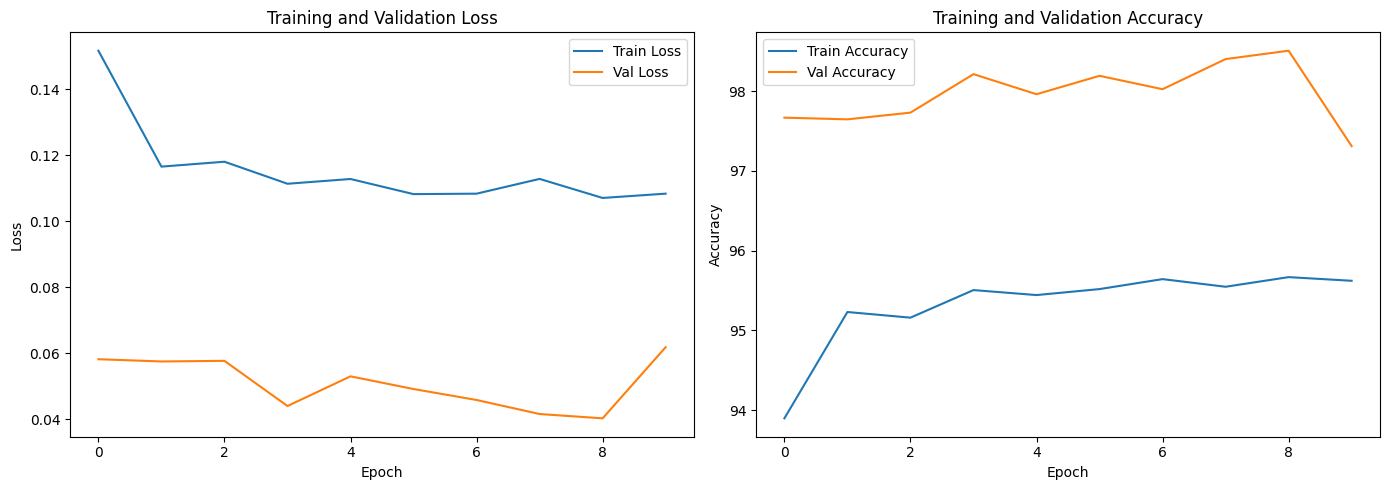

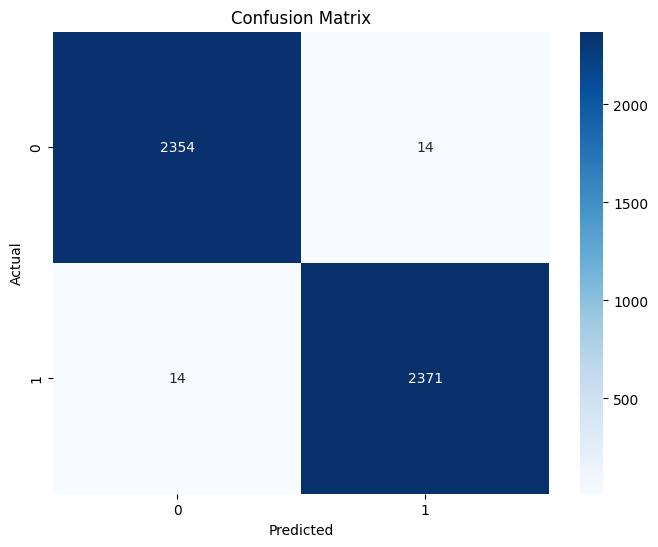

<Figure size 640x480 with 0 Axes>

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,5))

ax1.plot(train_losses, label = 'Train Loss')
ax1.plot(val_losses, label = 'Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
plt.savefig('Training and Validation Loss.png')

ax2.plot(train_accs, label = 'Train Accuracy')
ax2.plot(val_accs, label = 'Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
plt.savefig('Training and Validation Accuracy.png')

plt.tight_layout()
plt.show()

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()
plt.savefig('confusion_matrix.png')

In [ ]:
plt.imwrite("Training and Validation Loss", )

In [9]:
# ===== MobileNetV2 Model Setup (Complete Cell) =====


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained MobileNetV2
model = models.mobilenet_v2(
    weights=models.MobileNet_V2_Weights.IMAGENET1K_V1
)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier for binary classification
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2)

# IMPORTANT: unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Move model to device
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (ONLY classifier parameters)
optimizer = optim.Adam(
    model.classifier.parameters(),
    lr=0.001
)



In [10]:
num_epochs = 10
from tqdm import tqdm
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100*correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss = val_running_loss / len(val_loader)
    val_acc = 100*val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print ( f'Saved best model with val_acc : {val_acc :.2f}%')

    print (f'Epoch[{epoch+1}/{num_epochs}]', flush=True)
    print (f'Train Loss:{train_loss:.4f},Train Acc:{ train_acc :.2f}%', flush=True)
    print (f'Val Loss:{ val_loss :.4f},Val Acc:{val_acc :.2f}%',  flush=True)
    print('',  flush=True)


Epoch 1/10: 100%|██████████| 750/750 [12:48<00:00,  1.02s/it]


Saved best model with val_acc : 97.82%
Epoch[1/10]
Train Loss:0.1533,Train Acc:93.73%
Val Loss:0.0559,Val Acc:97.82%



Epoch 2/10: 100%|██████████| 750/750 [11:43<00:00,  1.07it/s]


Saved best model with val_acc : 97.84%
Epoch[2/10]
Train Loss:0.1287,Train Acc:94.56%
Val Loss:0.0549,Val Acc:97.84%



Epoch 3/10: 100%|██████████| 750/750 [12:13<00:00,  1.02it/s]


Saved best model with val_acc : 97.98%
Epoch[3/10]
Train Loss:0.1369,Train Acc:94.50%
Val Loss:0.0508,Val Acc:97.98%



Epoch 4/10: 100%|██████████| 750/750 [13:26<00:00,  1.08s/it]


Epoch[4/10]
Train Loss:0.1285,Train Acc:94.75%
Val Loss:0.0612,Val Acc:97.77%



Epoch 5/10: 100%|██████████| 750/750 [11:25<00:00,  1.09it/s]


Saved best model with val_acc : 98.15%
Epoch[5/10]
Train Loss:0.1322,Train Acc:94.65%
Val Loss:0.0497,Val Acc:98.15%



Epoch 6/10: 100%|██████████| 750/750 [10:42<00:00,  1.17it/s]


Epoch[6/10]
Train Loss:0.1266,Train Acc:94.88%
Val Loss:0.0502,Val Acc:97.94%



Epoch 7/10: 100%|██████████| 750/750 [11:03<00:00,  1.13it/s]


Epoch[7/10]
Train Loss:0.1337,Train Acc:94.78%
Val Loss:0.0585,Val Acc:97.84%



Epoch 8/10: 100%|██████████| 750/750 [09:35<00:00,  1.30it/s]


Epoch[8/10]
Train Loss:0.1300,Train Acc:94.87%
Val Loss:0.0483,Val Acc:97.98%



Epoch 9/10: 100%|██████████| 750/750 [09:29<00:00,  1.32it/s]


Epoch[9/10]
Train Loss:0.1327,Train Acc:94.76%
Val Loss:0.0512,Val Acc:97.92%



Epoch 10/10: 100%|██████████| 750/750 [09:45<00:00,  1.28it/s]


Epoch[10/10]
Train Loss:0.1360,Train Acc:94.58%
Val Loss:0.0660,Val Acc:97.50%



In [12]:
# ===== MobileNetV2 Fine-Tuning =====

# Load best trained MobileNet model
model.load_state_dict(torch.load("best_model.pth"))

# Unfreeze last feature block
for param in model.features[-1].parameters():
    param.requires_grad = True

# (Classifier is already trainable, but safe to re-enable)
for param in model.classifier.parameters():
    param.requires_grad = True

# New optimizer with small learning rate
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.0001
)

fine_tune_epochs = 5

for epoch in range(fine_tune_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"[Fine-tune Epoch {epoch+1}/{fine_tune_epochs}] "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Epoch 1/10: 100%|██████████| 750/750 [09:04<00:00,  1.38it/s]


[Fine-tune Epoch 1/5] Train Acc: 95.27% | Val Acc: 98.13%


Epoch 2/10: 100%|██████████| 750/750 [09:11<00:00,  1.36it/s]


[Fine-tune Epoch 2/5] Train Acc: 95.43% | Val Acc: 98.55%


Epoch 3/10: 100%|██████████| 750/750 [09:12<00:00,  1.36it/s]


[Fine-tune Epoch 3/5] Train Acc: 95.78% | Val Acc: 98.53%


Epoch 4/10: 100%|██████████| 750/750 [07:43<00:00,  1.62it/s]


[Fine-tune Epoch 4/5] Train Acc: 95.84% | Val Acc: 98.47%


Epoch 5/10: 100%|██████████| 750/750 [09:06<00:00,  1.37it/s]


[Fine-tune Epoch 5/5] Train Acc: 96.11% | Val Acc: 98.74%


In [14]:
torch.save(model.state_dict(), "best_mobilenetv2_finetuned.pth")


In [15]:
model.load_state_dict(torch.load('best_mobilenetv2_finetuned.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print ( f'Test Accuracy:{test_accuracy :.2f}%')

Test Accuracy:97.75%


In [ ]:
def visualize_predictions(model, dataloader, class_names, device):
    model.eval()

    correct = []
    incorrect = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                img = images[i].cpu()
                label = labels[i].cpu().item()
                pred = preds[i].cpu().item()

                if pred == label and len(correct) < 10:
                    correct.append((img, label, pred))
                elif pred != label and len(incorrect) < 10:
                    incorrect.append((img, label, pred))

                if len(correct) == 10 and len(incorrect) == 10:
                    break
            if len(correct) == 10 and len(incorrect) == 10:
                break

    def show_grid(samples, title):
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        fig.suptitle(title, fontsize=16)

        for ax, (img, label, pred) in zip(axes.flatten(), samples):
            img = img.permute(1, 2, 0)

            img = img * torch.tensor([0.229, 0.224, 0.225]) + \
                  torch.tensor([0.485, 0.456, 0.406])
            img = img.clamp(0, 1)

            ax.imshow(img)
            ax.set_title(
                f"Pred: {class_names[pred]}\nTrue: {class_names[label]}",
                fontsize=10
            )
            ax.axis("off")

        plt.tight_layout()
        plt.show()

    show_grid(correct, "Correctly Classified Images")
    show_grid(incorrect, "Incorrectly Classified Images")


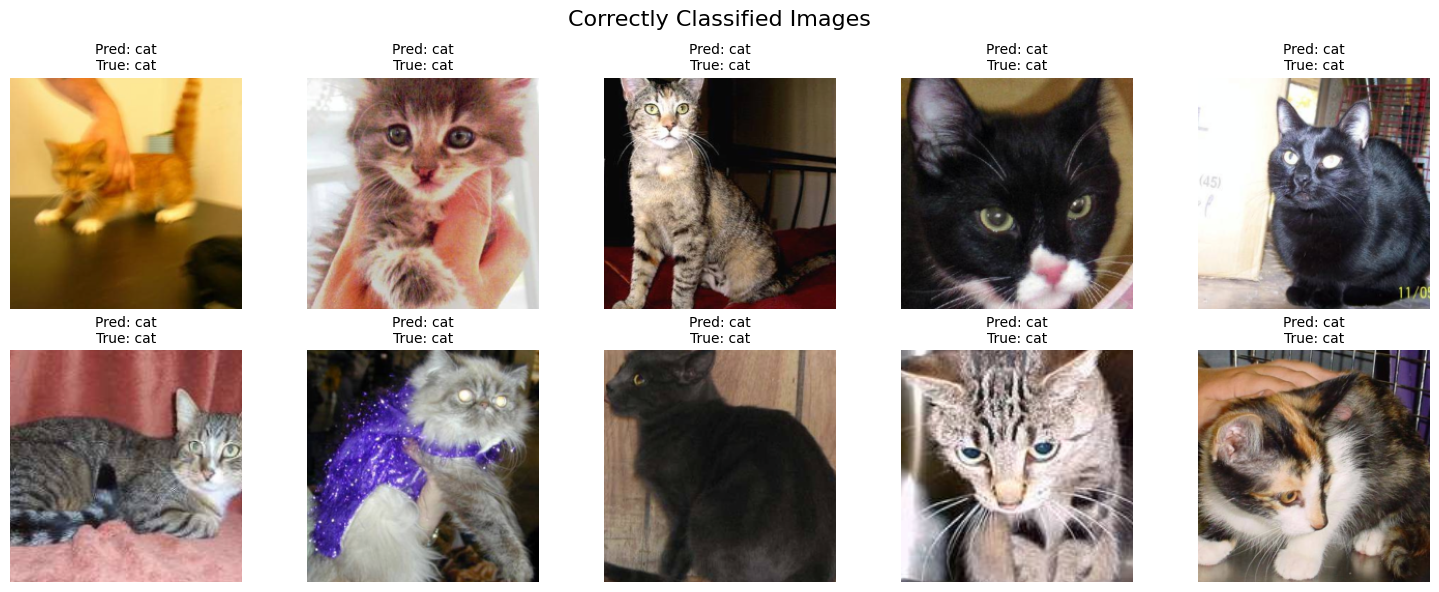

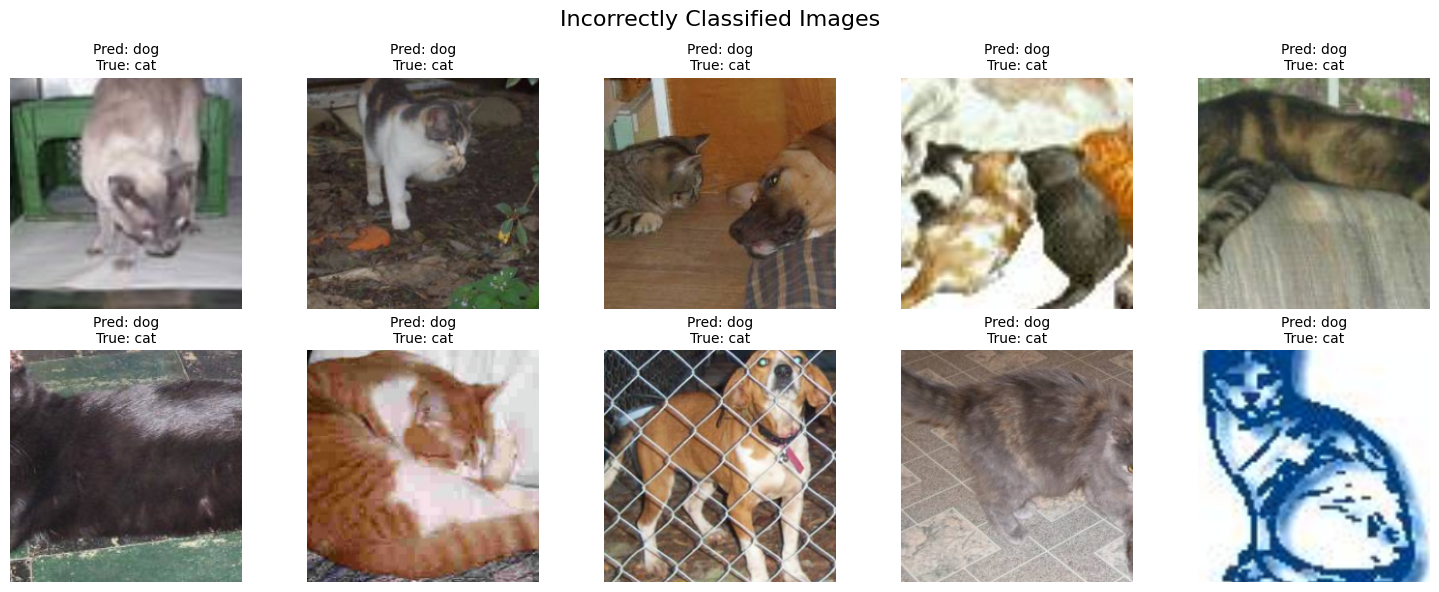

In [10]:
class_names = ["cat", "dog"]  # adjust if needed
model.load_state_dict(torch.load('best_resnet_finetuned.pth'))
visualize_predictions(
    model=model,
    dataloader=test_loader,
    class_names=class_names,
    device=device
)